In [110]:

import math

import numpy
import pandas
import matplotlib.pyplot as plt
import seaborn

import tensorflow
from tensorflow import keras


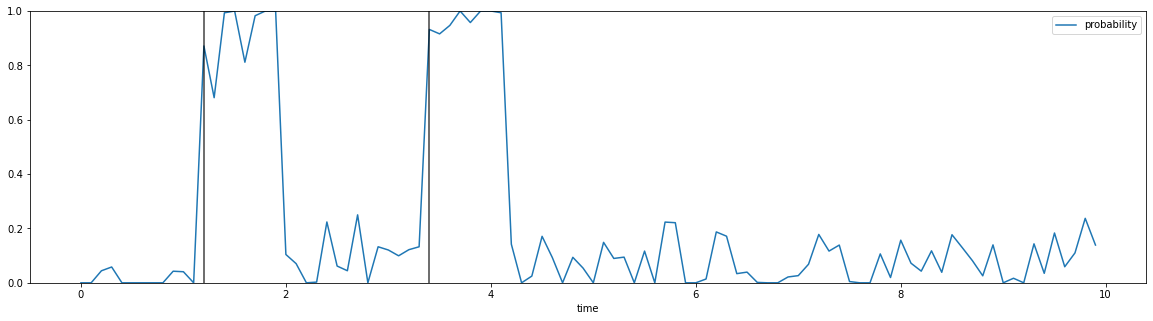

In [191]:


def generate_event_detections(length,
                              start_low=0.1, start_high=0.5,
                              width_mean=0.05, width_std=0.02,
                              dist_mean=0.3, dist_std=0.1,
                              high_mean=0.95, high_std=0.1,
                              low_mean=0.05, low_std=0.1,
                              clip_max=1.0, clip_min=0.0):
    
    gen = numpy.random.default_rng()
    
    a = gen.normal(low_mean, low_std, size=length)
    
    def insert_event(a, start):
        width = 1 + numpy.clip(gen.normal(width_mean*length, width_std*length, size=None), 0.0, length)
        width = int(width)
        values = gen.normal(high_mean, high_std, size=width)
        end = start+width
        if end >= len(a):
            width -= (len(a)-end)
            end = len(a)
            
        #print(start, end, width, len(values), numpy.median(values))
        a[start:end] = values
        return width
    
    # first event
    first_start = int(gen.uniform(start_low*length, start_high*length, size=None))
    first_width = insert_event(a, first_start)
        
    # second event
    second_start = int(first_start + gen.normal(dist_mean*length, dist_std*length, size=None))
    second_width = insert_event(a, second_start)
      
    out = numpy.clip(a, clip_min, clip_max)
    return first_start, second_start, out


def plot_detection(p, ax=None, dt=0.1, time_markers=[]):
    
    tt = numpy.arange(len(p))*dt
    ev = pandas.DataFrame({
        'time': tt,
        'probability': p, 
    }).set_index('time')

    if ax is None:
        fig, ax = plt.subplots(1, figsize=(20,5))
    
    ev.plot(ax=ax)

    for t in time_markers:
        ax.axvline(t, color='black', alpha=0.75)
        
    ax.set_ylim(0.0, 1.0)


dt = 0.1
t1, t2, p = generate_event_detections(100)
plot_detection(p, time_markers=[t1*dt, t2*dt], dt=dt)


In [192]:
def generate_detections(length=100, n=10000):
    ss = []
    for _ in range(n):
        try:
            d = generate_event_detections(length=length)
        except Exception:
            continue # failed, just ignore
        ss.append(d)
    df = pandas.DataFrame.from_records(ss, columns=['t1', 't2', 'detections'])
    df['distance'] = df['t2'] - df['t1']
    return df

detections = generate_detections(length=100)
detections

,t1,t2,detections,distance
0,28,72,"[0.009650483391762263, 0.2758384638282921, 0.0...",44
1,17,44,"[0.0, 0.0461656228281481, 0.0, 0.0, 0.25385368...",27
2,42,80,"[0.09642363469309168, 0.11606730931793745, 0.2...",38
3,22,61,"[0.03369381642594759, 0.0, 0.0, 0.211874311037...",39
4,45,77,"[0.21646497221272537, 0.03895346978377071, 0.0...",32
...,...,...,...,...
9934,27,39,"[0.16827393715053446, 0.1398551964211655, 0.15...",12
9935,37,72,"[0.0, 0.0, 0.03199779236525741, 0.0, 0.0, 0.02...",35
9936,21,29,"[0.08533355055117889, 0.10625840682732358, 0.2...",8
9937,34,36,"[0.08766615922936155, 0.15569606250772122, 0.0...",2


<AxesSubplot:xlabel='distance', ylabel='Count'>

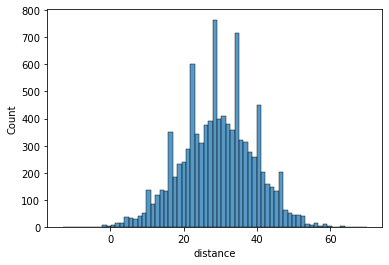

In [193]:
seaborn.histplot(data=detections, x='distance')

1159    None
3725    None
dtype: object

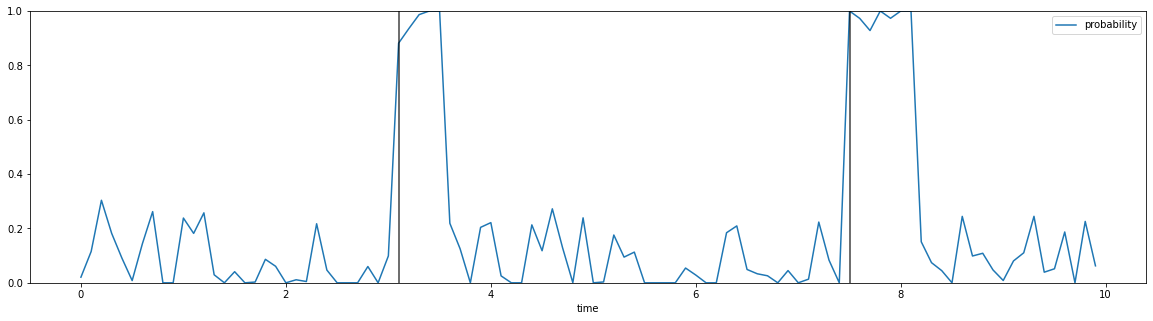

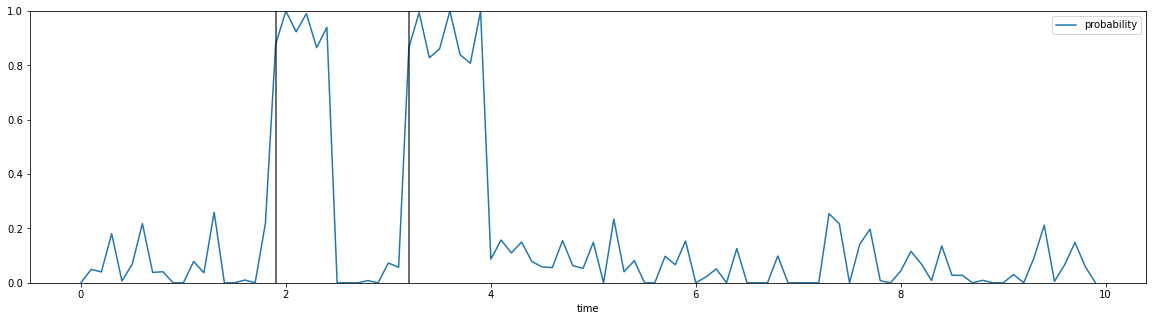

In [194]:
def plot_det(row):
    dt = 0.1
    plot_detection(row['detections'], dt=dt, time_markers=[row['t1']*dt, row['t2']*dt])
    
detections.sample(n=2).apply(plot_det, axis=1)

In [219]:

def build_mlp(input_shape, hidden_layers=[]):
    from tensorflow.keras import Model
    from tensorflow.keras.layers import Input,Dense
    
    input = Input(shape=input_shape)
    x = input
    for neurons in hidden_layers:
         x = Dense(neurons, activation='relu')(x)

    output = Dense(1, activation='linear')(x)
    model = Model(inputs=input, outputs=output)
    return model

def build_1dcnn(input_shape, hidden_layers=[], filters=5, dropout=0.0, downsample=1):
    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import Input,Dense,Reshape,Conv1D,Flatten,Dropout
    
    hiddens = [ Dense(n, activation='relu') for n in hidden_layers ]
    input_size = input_shape[0]
    
    model = Sequential([
        Input(shape=input_shape),
        Reshape((-1,1)),
        Conv1D(filters=filters, kernel_size=20, activation='relu', strides=downsample),
        Flatten(),
        *hiddens,
        Dropout(dropout),
        Dense(1)
    ])
    return model


X = numpy.stack(detections['detections'])
Y = detections['distance'] * dt

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)

model = build_mlp((X.shape[1],), hidden_layers=[6,20,20,20])
model = build_1dcnn((X.shape[1],), hidden_layers=[10,20,20,20])
model.summary()

tf = tensorflow
import tensorflow.keras.optimizers
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-2),
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

print(X_train.shape)
model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=300, batch_size=128*8)


Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_33 (Reshape)         (None, 100, 1)            0         
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 81, 5)             105       
_________________________________________________________________
flatten_31 (Flatten)         (None, 405)               0         
_________________________________________________________________
dense_453 (Dense)            (None, 10)                4060      
_________________________________________________________________
dense_454 (Dense)            (None, 20)                220       
_________________________________________________________________
dense_455 (Dense)            (None, 20)                420       
_________________________________________________________________
dense_456 (Dense)            (None, 20)              

In [196]:
Y_val

2531    3.3
3975    2.3
4338    2.4
2205    3.1
4615    1.9
       ... 
811     1.5
3586    3.2
7406    2.5
802     3.9
2714    3.7
Name: distance, Length: 1591, dtype: float64

/usr/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


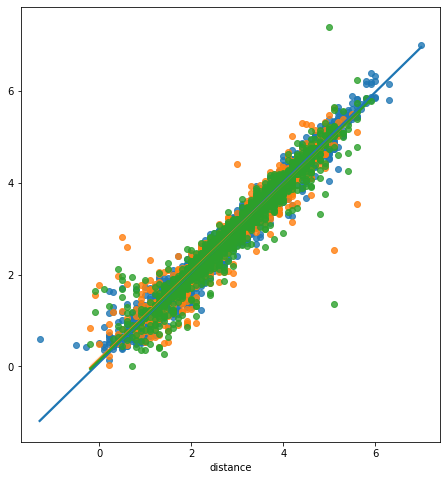

In [220]:
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)
Y_pred_val.shape
fig, ax = plt.subplots(1, figsize=(8,8))
seaborn.regplot(Y_train, Y_pred_train[:,0])
seaborn.regplot(Y_val, Y_pred_val[:,0])
seaborn.regplot(Y_test, Y_pred_test[:,0])
ax.set_aspect('equal')

In [224]:
numpy.sqrt(2)

1.4142135623730951

In [225]:
1.41**2

1.9880999999999998

In [166]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

cross_val_score(RandomForestRegressor(), X, Y, scoring='neg_mean_squared_error', cv=2)

array([-0.81148866, -0.73637066])

In [169]:
from sklearn.dummy import DummyRegressor
cross_val_score(DummyRegressor(), X, Y, scoring='neg_mean_squared_error', cv=5)

array([-0.99801273, -1.0866779 , -0.96843161, -0.96612492, -0.91143225])